In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load both datasets
ages_df = pd.read_csv('/Users/larsheijnen/VSCode_S2/Thesis/ages-PPMI/Age_at_visit_21Mar2025.csv')
motor_updrs_df = pd.read_csv('/Users/larsheijnen/VSCode_S2/Thesis/Motor-PPMI/MDS-UPDRS_Part_III_21Mar2025.csv')

# Convert columns to appropriate types
ages_df['PATNO'] = ages_df['PATNO'].astype(str)
ages_df['AGE_AT_VISIT'] = pd.to_numeric(ages_df['AGE_AT_VISIT'])
motor_updrs_df['PATNO'] = motor_updrs_df['PATNO'].astype(str)

In [11]:
ages_patients = set(ages_df['PATNO'].unique())
motor_updrs_patients = set(motor_updrs_df['PATNO'].unique())

In [12]:
print(f"Number of unique patients in age data: {len(ages_patients)}")
print(f"Number of unique patients in MOTOR-UPDRS data: {len(motor_updrs_patients)}")
print(f"Patients in UPDRS but not in ages: {motor_updrs_patients - ages_patients}")
print(f"Patients in ages but not in MOTOR-UPDRS: {ages_patients - motor_updrs_patients}")

Number of unique patients in age data: 4850
Number of unique patients in MOTOR-UPDRS data: 4313
Patients in UPDRS but not in ages: {'41358', '3005', '3329'}
Patients in ages but not in MOTOR-UPDRS: {'105512', '171783', '157540', '359548', '159461', '354444', '168124', '292770', '349667', '149812', '130468', '177087', '164507', '171781', '360867', '122016', '140680', '142001', '114269', '182910', '273172', '142330', '368849', '101176', '233935', '121531', '223610', '139750', '141849', '157411', '211867', '212129', '367395', '352349', '256639', '252153', '357928', '224852', '151311', '101836', '301058', '342068', '369670', '213153', '239077', '243042', '60120', '102428', '369343', '255209', '356713', '353077', '106956', '408912', '222934', '359803', '421273', '131611', '185552', '147159', '292875', '142087', '260468', '349525', '356621', '162234', '292870', '102328', '163023', '102525', '142325', '217020', '312296', '4007', '356372', '245581', '354540', '240094', '102303', '310677', '408

In [14]:
matching_patients = ages_patients.intersection(updrs_patients)
print(f"Number of matching patients: {len(matching_patients)}")

Number of matching patients: 4310


In [17]:
alignment_results = {}
for patno in matching_patients:
    age_events = set(ages_df[ages_df['PATNO'] == patno]['EVENT_ID'])
    updrs_events = set(motor_updrs_df[motor_updrs_df['PATNO'] == patno]['EVENT_ID'])
    
    common_events = age_events.intersection(updrs_events)
    only_in_ages = age_events - updrs_events
    only_in_updrs = updrs_events - age_events
    
    alignment_results[patno] = {
        'common_events': len(common_events),
        'only_in_ages': len(only_in_ages),
        'only_in_updrs': len(only_in_updrs),
        'alignment_percentage': len(common_events) / len(age_events.union(updrs_events)) * 100
    }

In [18]:
alignment_df = pd.DataFrame(alignment_results).T
mean_alignment = alignment_df['alignment_percentage'].mean()
print(f"\nMean visit alignment percentage: {mean_alignment:.2f}%")
print(f"Total common events: {alignment_df['common_events'].sum()}")
print(f"Total events only in ages: {alignment_df['only_in_ages'].sum()}")
print(f"Total events only in UPDRS: {alignment_df['only_in_updrs'].sum()}")



Mean visit alignment percentage: 72.55%
Total common events: 26626.0
Total events only in ages: 7382.0
Total events only in UPDRS: 235.0


In [19]:
merged_df = pd.merge(
    ages_df, 
    updrs_df.drop(['REC_ID'], axis=1),  # Drop REC_ID to avoid duplicate columns
    on=['PATNO', 'EVENT_ID'], 
    how='inner'
)

In [21]:
print(f"Number of unique patients in merged data: {merged_df['PATNO'].nunique()}")
print(f"Number of unique visits in merged data: {merged_df['EVENT_ID'].nunique()}")

# Calculate NP3TOT availability
np3tot_available = merged_df['NP3TOT'].notna().sum()
print(f"Number of records with NP3TOT score available: {np3tot_available} ({np3tot_available/len(merged_df)*100:.1f}%)")


Number of unique patients in merged data: 4298
Number of unique visits in merged data: 41
Number of records with NP3TOT score available: 25993 (80.7%)


In [22]:
print("\nUPDRS scores by age group:")
merged_df['age_group'] = pd.cut(merged_df['AGE_AT_VISIT'], bins=[30, 50, 60, 70, 80, 100], 
                              labels=['30-49', '50-59', '60-69', '70-79', '80+'])
updrs_by_age = merged_df.groupby('age_group')['NP3TOT'].agg(['mean', 'median', 'count'])
print(updrs_by_age)


UPDRS scores by age group:
                mean  median  count
age_group                          
30-49      16.837255    15.0   1530
50-59      16.201375    15.0   5090
60-69      15.107615    12.0  10900
70-79      18.881027    17.0   7363
80+        23.710383    22.0   1098


/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_4666/2510553401.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  updrs_by_age = merged_df.groupby('age_group')['NP3TOT'].agg(['mean', 'median', 'count'])


In [23]:
merged_df.to_csv('/Users/larsheijnen/VSCode_S2/Thesis/merged_age_updrs_data.csv', index=False)

/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_4666/2061791868.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  updrs_by_age[['mean']].plot(kind='bar', yerr=merged_df.groupby('age_group')['NP3TOT'].std(), ax=plt.gca())


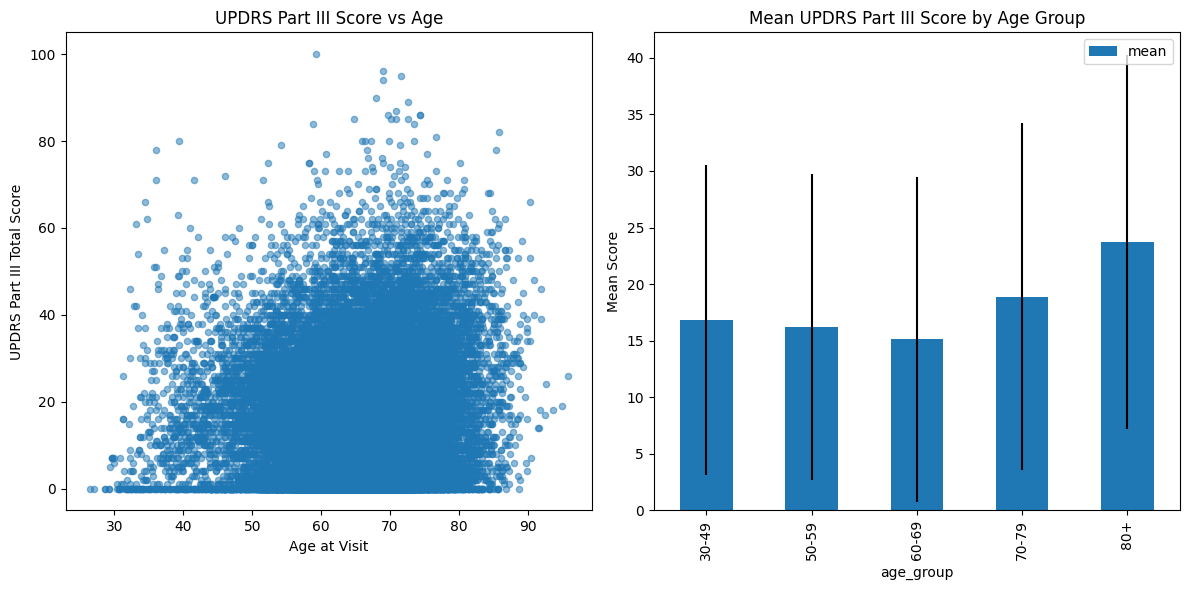

In [24]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
merged_df.plot.scatter(x='AGE_AT_VISIT', y='NP3TOT', alpha=0.5, ax=plt.gca())
plt.title('UPDRS Part III Score vs Age')
plt.xlabel('Age at Visit')
plt.ylabel('UPDRS Part III Total Score')

plt.subplot(1, 2, 2)
updrs_by_age[['mean']].plot(kind='bar', yerr=merged_df.groupby('age_group')['NP3TOT'].std(), ax=plt.gca())
plt.title('Mean UPDRS Part III Score by Age Group')
plt.ylabel('Mean Score')
plt.tight_layout()
plt.savefig('/Users/larsheijnen/VSCode_S2/Thesis/updrs_by_age.png')
plt.show()